This demo demonstrates how to use the trained MSAE model to detect and manipulate concepts in preprocessed CLIP images, similar to the methods described in the paper. The MSAE model used here is trained on ViT-L CLIP with an expansion rate of 8 and reverse weighting (RW). The model was trained and provided on the main page of the repository. For this demo, we will use the [ImageNet100 dataset](https://www.kaggle.com/datasets/ambityga/imagenet100).

In [1]:
%load_ext autoreload
%autoreload 2

To demonstrate the use of MSAE, we will first show how to extract SAE representations from CLIP representations. Additionally, we will display the MSAE metrics on the ImageNet100 dataset.

In [2]:
import os
import json
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

from huggingface_hub import hf_hub_download

import clip
import metrics
from sae import SAE

/Users/vladimirzaigrajew/Documents/projects/MSAE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The dataset was downloaded from the Kaggle link provided above. For simplicity, we will use only the validation set of the dataset in this demonstration.

In [3]:
with open('imagenet100/Labels.json', 'r') as f:
    labels = json.load(f)

In [4]:
images = []

for label in os.listdir('imagenet100/val.X'):
    for filename in os.listdir(f'imagenet100/val.X/{label}'):
        images.append({
            'path': f'imagenet100/val.X/{label}/{filename}',
            'label': labels[label],
        })

df = pd.DataFrame(images)
df

path  \
0     imagenet100/val.X/n01740131/ILSVRC2012_val_000...   
1     imagenet100/val.X/n01740131/ILSVRC2012_val_000...   
2     imagenet100/val.X/n01740131/ILSVRC2012_val_000...   
3     imagenet100/val.X/n01740131/ILSVRC2012_val_000...   
4     imagenet100/val.X/n01740131/ILSVRC2012_val_000...   
...                                                 ...   
4995  imagenet100/val.X/n02012849/ILSVRC2012_val_000...   
4996  imagenet100/val.X/n02012849/ILSVRC2012_val_000...   
4997  imagenet100/val.X/n02012849/ILSVRC2012_val_000...   
4998  imagenet100/val.X/n02012849/ILSVRC2012_val_000...   
4999  imagenet100/val.X/n02012849/ILSVRC2012_val_000...   

                                 label  
0     night snake, Hypsiglena torquata  
1     night snake, Hypsiglena torquata  
2     night snake, Hypsiglena torquata  
3     night snake, Hypsiglena torquata  
4     night snake, Hypsiglena torquata  
...                                ...  
4995                             crane  
4996                             crane  
4997                             crane  
4998                             crane  
4999                             crane  

[5000 rows x 2 columns]

The dataset labels and paths are loaded into a dataframe. Next, we will load the CLIP model from the official [OpenAI repository](https://github.com/openai/CLIP).

In [5]:
model, preprocess = clip.load("ViT-L/14", device="cpu")

The `SAE` wrapper provides a simple way to load and experiment with the MSAE model. For more advanced use, the model can be accessed directly through the `sae_model.model` attribute. Additionally, the original version of MSAE was trained with centering, and since the version used here is also trained with centering, the wrapper automatically centers the CLIP representations before passing them to the MSAE model.

In [6]:
weights_path = hf_hub_download(
    repo_id="WolodjaZ/MSAE",
    filename="ViT-L_14/centered/6144_768_TopKReLU_64_RW_False_False_0.0_cc3m_ViT-L~14_train_image_2905936_768.pth"
)
sae_model = SAE(weights_path)

In [7]:
sae_model.model

Autoencoder(
  (latent_soft_cap): Identity()
  (activation): TopK(
    (act_fn): ReLU()
  )
  (dead_activations): TopK(
    (act_fn): ReLU()
  )
)

In [8]:
sae_model.mean.mean(), sae_model.scaling_factor

(tensor(-0.0038), tensor(2.0259))

Now, let's extract the CLIP and MSAE representations from the dataset. The CLIP representations are extracted using the clip model, and the MSAE representations are extracted using the SAE wrapper. We will also calculate the following metrics from the paper to validate the MSAE model's performance on this dataset:
- `fvu`: Fraction of variance unexplained
- `mae`: Mean absolute error
- `cs`: Cosine similarity
- `l0`: Average number of zero elements in the latents
- `highest_magnitude`: Maximum SAE activation value in the latents

In [9]:
sae_representations = []
clip_representations = []
sae_reconstructed = []
image_paths = []
metrics_all = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    image_paths.append(row['path'])
    image = Image.open(row['path'])
    input = preprocess(image).unsqueeze(0)

    with torch.no_grad():
        features = model.encode_image(input)
        post_reconstructed, reconstructed, full_latents = sae_model(features.to(torch.float32))
        
    clip_representations.append(features.cpu().flatten())
    sae_representations.append(full_latents.cpu().flatten())
    sae_reconstructed.append(post_reconstructed.cpu().flatten())
    
    fvu = metrics.explained_variance(features, post_reconstructed)
    mae = metrics.normalized_mean_absolute_error(features, post_reconstructed)
    cs = torch.nn.functional.cosine_similarity(features, post_reconstructed)
    l0 = metrics.l0_messure(full_latents)
    highest_magnitude = full_latents.max(dim=-1).values
    metrics_all.append({
        'fvu': fvu,
        'mae': mae.item(),
        'cs': cs.mean().item(),
        'l0': l0.item(),
        'highest_magnitude': highest_magnitude.mean().item()
    })

clip_representations = torch.stack(clip_representations)
sae_representations = torch.stack(sae_representations)
sae_reconstructed = torch.stack(sae_reconstructed)
clip_representations.shape, sae_representations.shape

100%|██████████| 5000/5000 [49:46<00:00,  1.67it/s]  


(torch.Size([5000, 768]), torch.Size([5000, 6144]))

In [10]:
metrics_all = pd.DataFrame(metrics_all)
for col in metrics_all.columns:
    print(f'{col}: {metrics_all[col].mean()} ± {metrics_all[col].std()}')

fvu: 0.022881734255328773 ± 0.006112609885534271
mae: 0.18638541413247586 ± 0.019261920788663456
cs: 0.9887459955215454 ± 0.003006402882184978
l0: 0.9120718100309372 ± 0.006370994904913561
highest_magnitude: 8.242612818717957 ± 1.2105268748557092


The fvu, mae and cs indicate high reconstruction quality, while l0 and highest_magnitude provide insights into the sparsity and activation patterns of the latents.
To quickly analyze the MSAE activations, we can plot the distribution of the latents.

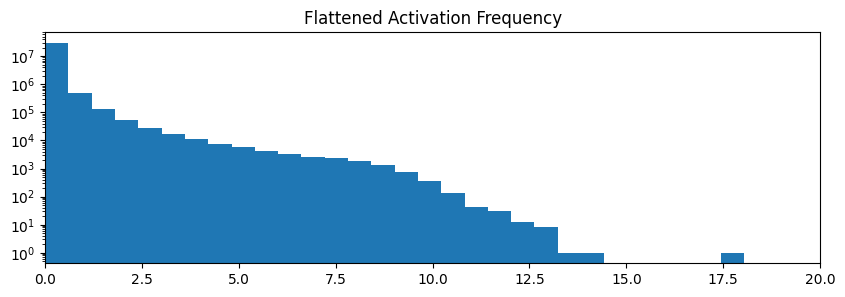

In [11]:
# plot histogram of activations
plt.figure(figsize=(10, 3))
plt.title("Flattened Activation Frequency")
plt.yscale('log')
plt.hist(sae_representations.flatten().cpu().numpy(), bins=30)
plt.xlim(0.0, 20)
plt.show()

A popular method to determine if a concept is present is to regularize the representations. Since activation values between 0 and 5 do not always signify the presence of a concept, we can calculate the mean and subtract it from the latents. This allows us to see how much the concept is present in the image compared to its average presence in the dataset.

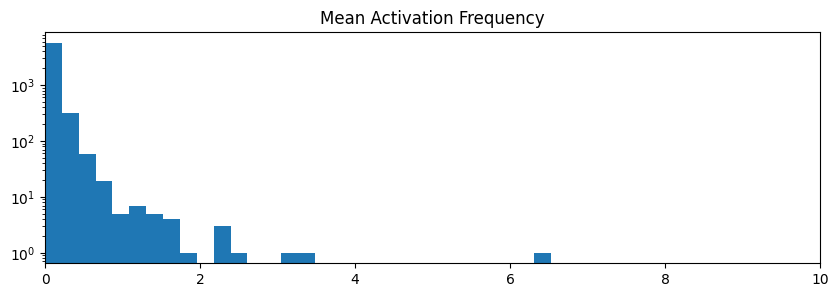

In [12]:
mean_activations = sae_representations.mean(dim=0)
std_activations = sae_representations.std(dim=0)

plt.figure(figsize=(10, 3))
plt.title("Mean Activation Frequency")
plt.yscale('log')
plt.hist(mean_activations.cpu().numpy(), bins=30)
plt.xlim(0.0, 10)
plt.show()

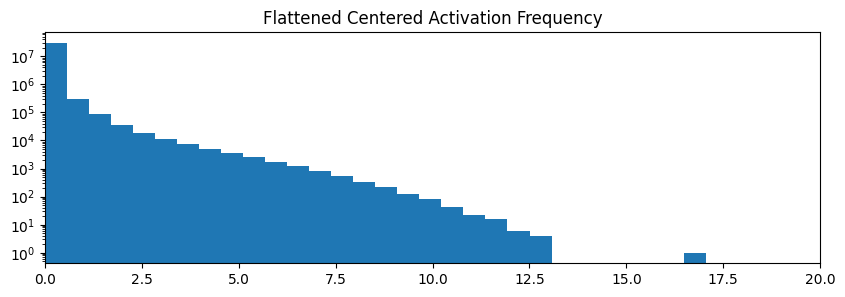

In [13]:
plt.figure(figsize=(10, 3))
plt.title("Flattened Centered Activation Frequency")
plt.yscale('log')
plt.hist(torch.nn.functional.relu(sae_representations-mean_activations).flatten().cpu().numpy(), bins=30)
plt.xlim(0.0, 20)
plt.show()

## Concept Detection and Validation

Next, we will visualize the top 10 activations in the MSAE latents for a given image to understand which concepts are most strongly activated. We will focus on the image with the highest activation value in the MSAE.

argmax index: 5465, value: 18.04193115234375


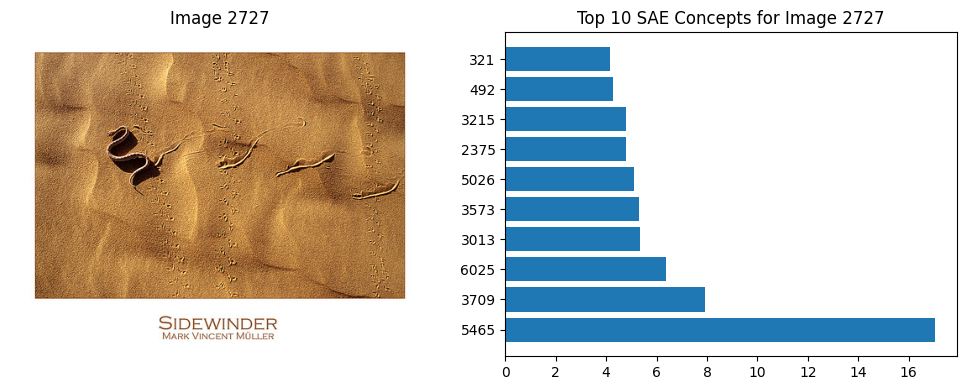

In [14]:
image_index, argmax_index = torch.where(sae_representations == sae_representations.max())[0][0], torch.where(sae_representations == sae_representations.max())[1][0]
print(f'argmax index: {argmax_index}, value: {sae_representations[image_index, argmax_index]}')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
top_10 = (sae_representations - mean_activations)[image_index].topk(10)
ax[0].imshow(Image.open(image_paths[image_index]).convert('RGB'))
ax[0].axis('off')
ax[0].set_title(f'Image {image_index}')
ax[1].barh(range(10), top_10.values.cpu().numpy())
ax[1].set_yticks(range(10))
ax[1].set_yticklabels([i for i in top_10.indices.cpu().numpy()])
ax[1].set_title(f'Top 10 SAE Concepts for Image {image_index}')
plt.tight_layout()
plt.show()

The activation of concept `5465` is double that of the second most activated concept in the image, indicating its strong presence. However, the identity of the concept is unknown. To determine what this concept represents, we can examine the images with the highest activation values for it. This will help us understand the concept and its representation in the MSAE latents. Before analyzing concept `5465`, we will first look at the first five images from the dataset (labeled as "snake") to see if the concepts are consistent with the images.

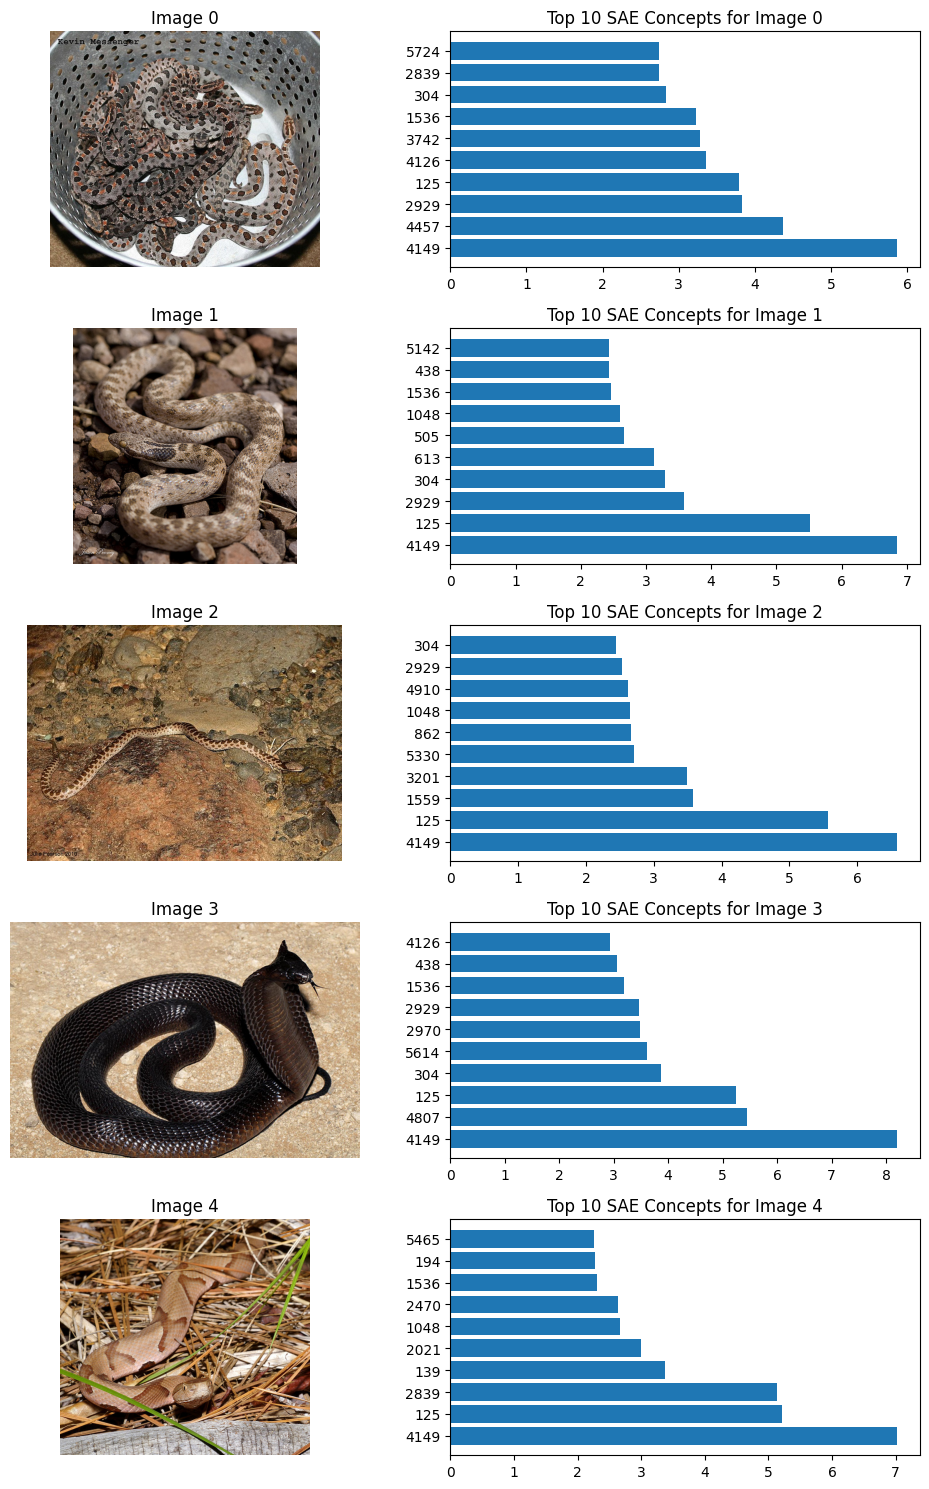

In [15]:
fig, ax = plt.subplots(5, 2, figsize=(10, 15))
for i in range(5):
    top_10 = (sae_representations[i] - mean_activations).topk(10)
    ax[i, 0].imshow(Image.open(image_paths[i]).convert('RGB'))
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f'Image {i}')
    ax[i, 1].barh(range(10), top_10.values.cpu().numpy())
    ax[i, 1].set_yticks(range(10))
    ax[i, 1].set_yticklabels([i for i in top_10.indices.cpu().numpy()])
    ax[i, 1].set_title(f'Top 10 SAE Concepts for Image {i}')
plt.tight_layout()
plt.show()

Concept `4149` shows the highest activation among our snake images. This strong correlation suggests that Concept `4149` is highly relevant to the "snake" classification. To further validate this, we'll now visualize the images that most strongly activate Concept `4149`. By examining these images, we can confirm if they consistently represent snakes, thereby reinforcing our understanding of this concept's meaning.

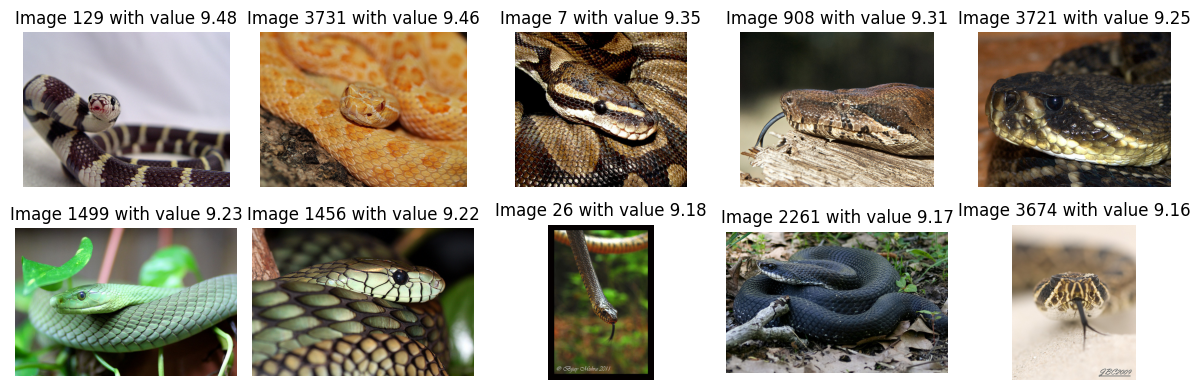

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
top_images = sae_representations[:, 4149].topk(10)
for i, axi in enumerate(ax.ravel()):
    axi.imshow(Image.open(image_paths[top_images.indices[i]]).convert('RGB'))
    axi.axis('off')
    axi.set_title(f'Image {top_images.indices[i]} with value {top_images.values[i].item():.2f}')
plt.tight_layout()
plt.show()

Based on our visual inspection, we can confirm that Concept `4149` is strongly associated with snake images. However, there's a more quantitative approach to validate this relationship, as demonstrated in the paper.

We can leverage the CLIP text encoder to assess the similarity between the "snake" concept and each SAE neuron. To achieve this, we'll execute the `sae_naming.py` script. We'll use the `vocab/clip_disect_20k.txt` vocabulary, which includes the "snake" concept. The script will compute the cosine similarity between each SAE neuron and the "snake" concept, resulting in a cosine similarity matrix of dimensions (vocab_size, num_sae_neurons). This matrix will highlight which neurons are most semantically similar to the "snake" concept.

In [18]:
vocab_path = hf_hub_download(
    repo_id="WolodjaZ/MSAE",
    filename="ViT-L_14/centered/Concept_Interpreter_6144_768_TopKReLU_64_RW_False_False_0.0_cc3m_ViT-L~14_train_image_2905936_768_disect_ViT-L~14_-1_text_20000_768.npy"
)
concept_match_scores = np.load(vocab_path)
concept_match_scores.shape

(20000, 6144)

In [19]:
with open('vocab/clip_disect_20k.txt', 'r') as f:
    vocab_names = [line.strip() for line in f.readlines()]
len(vocab_names)

20000

Let's see the highest scores for the MSAE neuron `4149`

In [20]:
top5_names = torch.from_numpy(concept_match_scores)[:,4149].topk(5)
for i in range(5):
    print(f'Top 5 concept for image 4149: {vocab_names[top5_names.indices[i]]} with score {top5_names.values[i].item():.2f}')

Top 5 concept for image 4149: snakes with score 0.19
Top 5 concept for image 4149: python with score 0.19
Top 5 concept for image 4149: snake with score 0.18
Top 5 concept for image 4149: viper with score 0.17
Top 5 concept for image 4149: serpent with score 0.17


The top vocabulary concepts assigned to this neuron are consistently snake-related concepts. This confirms the neuron's strong association with snake images. Let's now revisit the image exhibiting the highest activation value within the MSAE and identify the most prominent vocabulary concepts present in that specific image.

argmax index: 5465, value: 18.04193115234375


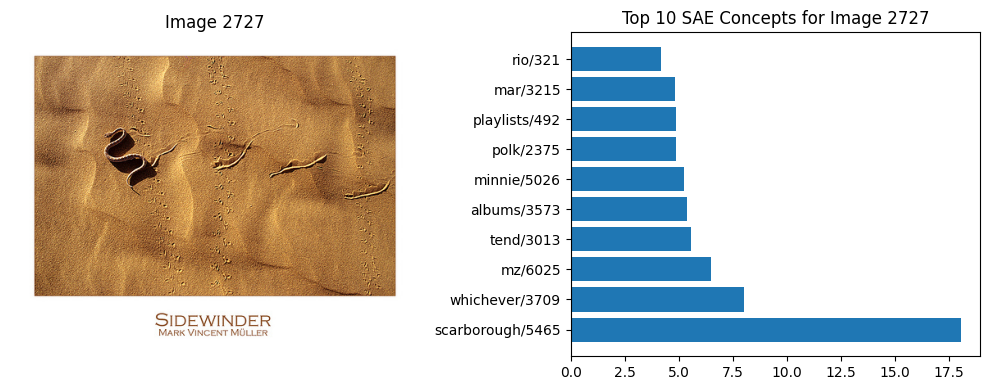

In [21]:
image_index, argmax_index = torch.where(sae_representations == sae_representations.max())[0][0], torch.where(sae_representations == sae_representations.max())[1][0]
print(f'argmax index: {argmax_index}, value: {sae_representations[image_index, argmax_index]}')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
top_10 = sae_representations[image_index].topk(10)
names = [vocab_names[concept_match_scores[:, i].argmax()]+f"/{i}" for i in top_10.indices.cpu().numpy()]
ax[0].imshow(Image.open(image_paths[image_index]).convert('RGB'))
ax[0].axis('off')
ax[0].set_title(f'Image {image_index}')
ax[1].barh(range(10), top_10.values.cpu().numpy())
ax[1].set_yticks(range(10))
ax[1].set_yticklabels(names)
ax[1].set_title(f'Top 10 SAE Concepts for Image {image_index}')
plt.tight_layout()
plt.show()

Interestingly, MSAE neuron `5465` is named "scarborough", a place in the UK. This naming appears to be unrelated to the actual concept represented by the neuron, in our assessment. To validate this discrepancy, let's examine the top-matched vocabulary concepts for MSAE neuron `5465`.

In [22]:
top5_names = torch.from_numpy(concept_match_scores)[:,5465].topk(5)
for i in range(5):
    print(f'Top 5 concept for image 5465: {vocab_names[top5_names.indices[i]]} with score {top5_names.values[i].item():.2f}')

Top 5 concept for image 5465: scarborough with score -0.08
Top 5 concept for image 5465: brilliant with score -0.08
Top 5 concept for image 5465: notable with score -0.08
Top 5 concept for image 5465: comm with score -0.08
Top 5 concept for image 5465: extraordinary with score -0.08


As anticipated, MSAE neuron `5465` doesn't appear to align with any concepts in our current vocabulary. The highest observed similarity score is near 0.0, strongly indicating a lack of correlation with any known terms. This suggests that neuron `5465` is an uninterpretable concept.

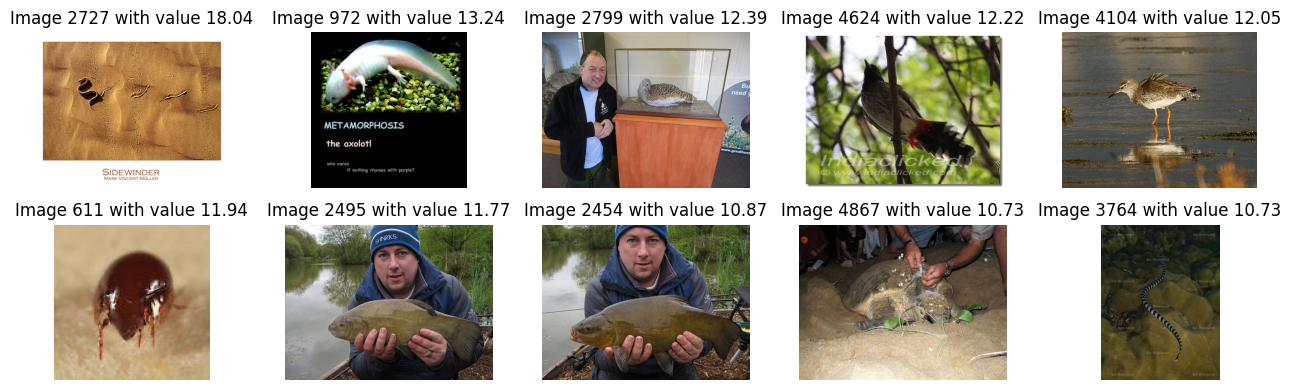

In [23]:
fig, ax = plt.subplots(2, 5, figsize=(13, 4))
top_images = sae_representations[:, 5465].topk(10)
for i, axi in enumerate(ax.ravel()):
    axi.imshow(Image.open(image_paths[top_images.indices[i]]).convert('RGB'))
    axi.axis('off')
    axi.set_title(f'Image {top_images.indices[i]} with value {top_images.values[i].item():.2f}')
plt.tight_layout()
plt.show()

## Similarity Search with CLIP and MSAE

As presented in Section 5.2 of the paper, we can utilize the MSAE model to interpret why certain images are similar to each other in CLIP space. This is achieved by examining the top activations within the MSAE latents of those similar images. This method can help us understand the underlying concepts that are driving the similarity between the images.

Additionally, we can look at the closest images not just in the CLIP space, but directly in the MSAE latent space itself. Although results might be similar to those obtained from the CLIP space, the MSAE approach is fundamentally interpretable from the ground up. Thus, we can expect that the results from the MSAE space will offer a more interpretable understanding than those derived solely from the CLIP space.

Let's first look at the top 5 images that are most active on the vocabulary concept `birds` within the MSAE latents.

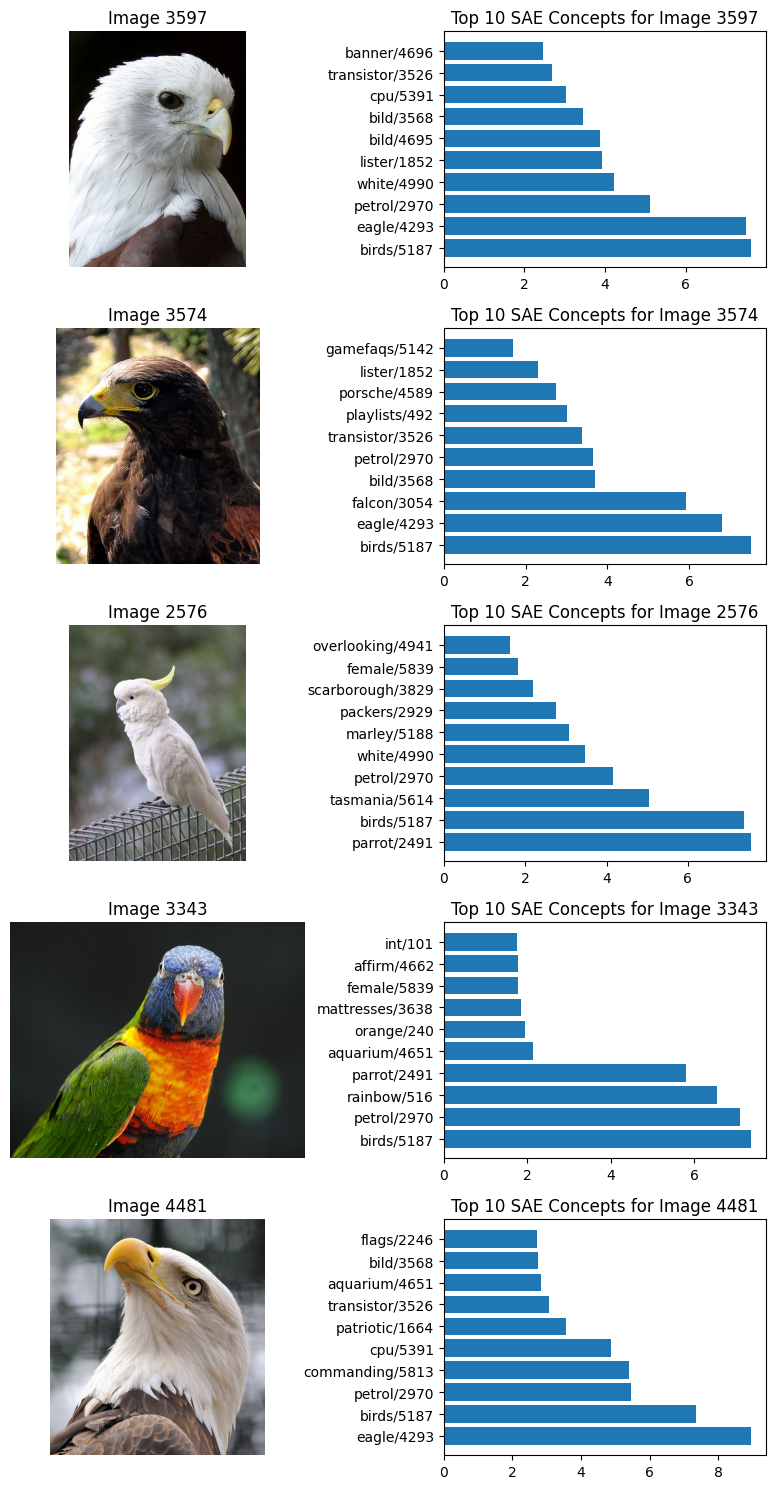

In [24]:
neuron_index = concept_match_scores[vocab_names.index('birds'), :].argmax()
top_5_birds = sae_representations[:, neuron_index].topk(5)
fig, ax = plt.subplots(5, 2, figsize=(8, 15))
for i, idx in enumerate(top_5_birds.indices.cpu().numpy()):
    top_10 = (sae_representations[idx] - mean_activations).topk(10)
    ax[i, 0].imshow(Image.open(image_paths[idx]).convert('RGB'))
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f'Image {idx}')
    ax[i, 1].barh(range(10), top_10.values.cpu().numpy())
    ax[i, 1].set_yticks(range(10))
    ax[i, 1].set_yticklabels([vocab_names[concept_match_scores[:, j].argmax()]+f"/{j}" for j in top_10.indices.cpu().numpy()])
    ax[i, 1].set_title(f'Top 10 SAE Concepts for Image {idx}')
plt.tight_layout()
plt.show()

Now, let's build Nearest Neighbors models for both the MSAE and CLIP representations to compare their results. We will use image `2576` as our reference.

In [25]:
clip_nn = NearestNeighbors(n_neighbors=5, metric='cosine')
clip_nn.fit(clip_representations.cpu().numpy())

NearestNeighbors(metric='cosine')

In [26]:
sae_nn = NearestNeighbors(n_neighbors=5, metric='manhattan')
sae_nn.fit((sae_representations).cpu().numpy())

NearestNeighbors(metric='manhattan')

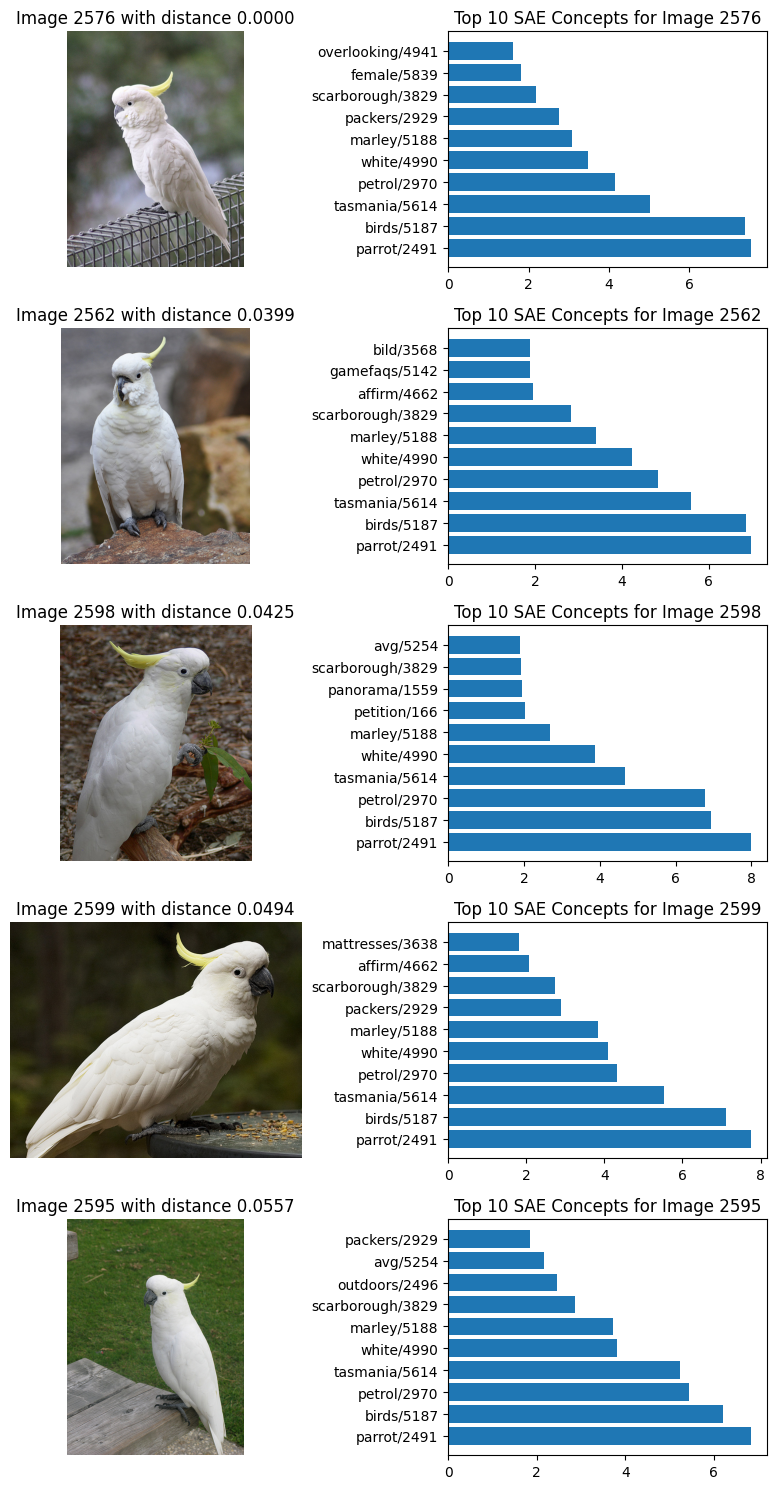

In [27]:
img_index = 2576
distance, neighbours = clip_nn.kneighbors(clip_representations[img_index].reshape(1, -1), 5, True)
fig, ax = plt.subplots(5, 2, figsize=(8, 15))
for i, (idx, dist) in enumerate(zip(neighbours.flatten(), distance.flatten())):
    top_10 = (sae_representations - mean_activations)[idx].topk(10)
    ax[i, 0].imshow(Image.open(image_paths[idx]).convert('RGB'))
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f'Image {idx} with distance {dist:.4f}')
    ax[i, 1].barh(range(10), top_10.values.cpu().numpy())
    ax[i, 1].set_yticks(range(10))
    ax[i, 1].set_yticklabels([vocab_names[concept_match_scores[:, j].argmax()]+f"/{j}" for j in top_10.indices.cpu().numpy()])
    ax[i, 1].set_title(f'Top 10 SAE Concepts for Image {idx}')
plt.tight_layout()
plt.show()


/Users/vladimirzaigrajew/Documents/projects/MSAE/.venv/lib/python3.12/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


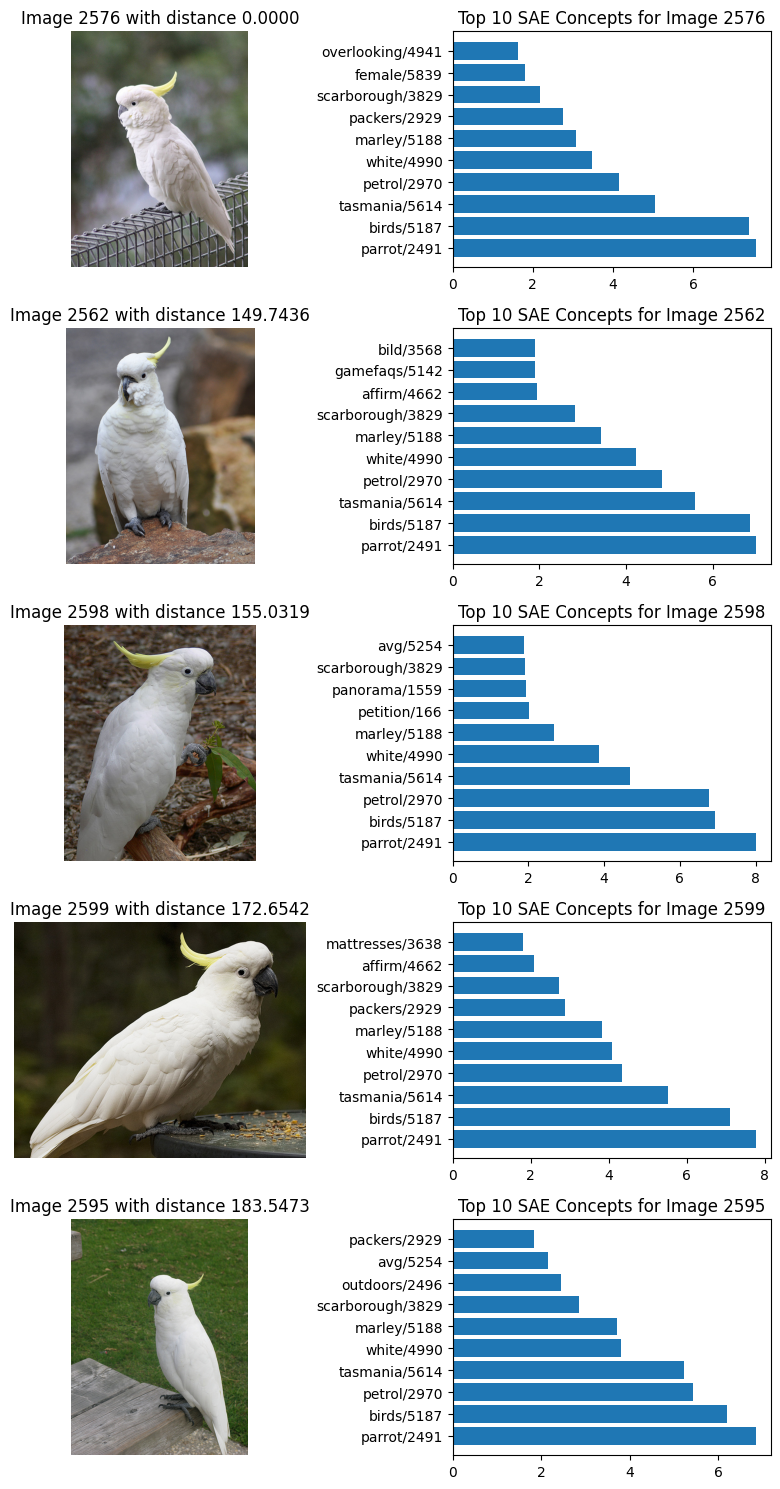

In [28]:
distance, neighbours = sae_nn.kneighbors(sae_representations[img_index].reshape(1, -1), 5, True)
fig, ax = plt.subplots(5, 2, figsize=(8, 15))
for i, (idx, dist) in enumerate(zip(neighbours.flatten(), distance.flatten())):
    top_10 = ((sae_representations - mean_activations)[idx]).topk(10)
    ax[i, 0].imshow(Image.open(image_paths[idx]).convert('RGB'))
    ax[i, 0].axis('off')
    ax[i, 0].set_title(f'Image {idx} with distance {dist:.4f}')
    ax[i, 1].barh(range(10), top_10.values.cpu().numpy())
    ax[i, 1].set_yticks(range(10))
    ax[i, 1].set_yticklabels([vocab_names[concept_match_scores[:, j].argmax()]+f"/{j}" for j in top_10.indices.cpu().numpy()])
    ax[i, 1].set_title(f'Top 10 SAE Concepts for Image {idx}')
plt.tight_layout()
plt.show()


As expected, both methods provide the same set of closest images in this instance. However, if the image database is large with various similar images, the MSAE approach may provide different results than the CLIP approach, as we saw when analyzing the full ImageNet dataset in the paper. The MSAE bar plot shows us the most active concepts, which adds value to the similarity search as we can see *why* images were chosen to be the most similar to the reference image based on these concepts. The CLIP approach does not provide this information. However, the cosine distance used in the CLIP approach is more interpretable as we know that it's bound to the range of <-1,1>, compared to an unbounded Manhattan distance used with MSAE.

## Concept Steering

As the SAE architecture is an autoencoder, we can change the activations in the MSAE latents and see how it affects the CLIP representations. We used this in the paper to do similarity search where we wanted to steer the search towards specific concepts by manipulating the latent space.

Let's now look for the most similar birds from our previous reference image `2576`, but this time we want to steer the search towards the `red` concept. First, let's see if we have such a concept and what images are most active on it.

In [29]:
vocab_names.index('red'), concept_match_scores[vocab_names.index('red')].argmax(), concept_match_scores[vocab_names.index('red')].max()

(553, 2882, 0.4105137)

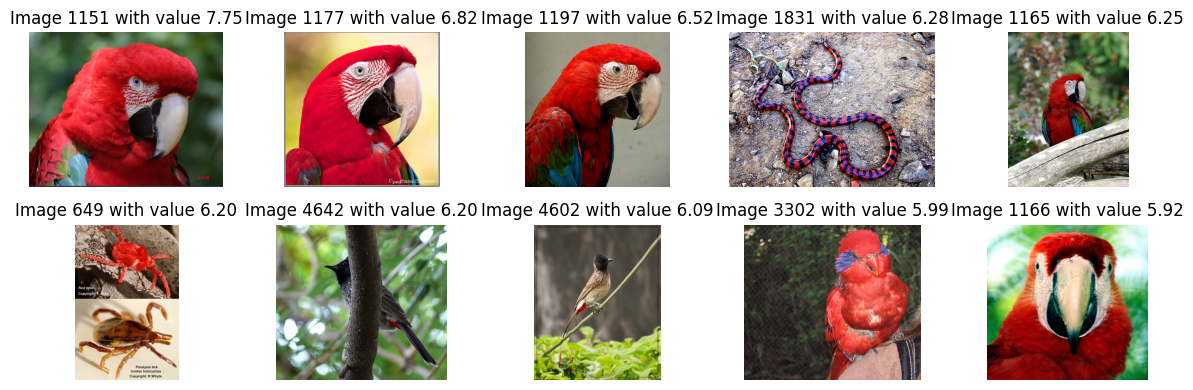

In [30]:
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
top_images = sae_representations[:, concept_match_scores[vocab_names.index('red')].argmax()].topk(10)
for i, axi in enumerate(ax.ravel()):
    axi.imshow(Image.open(image_paths[top_images.indices[i]]).convert('RGB'))
    axi.axis('off')
    axi.set_title(f'Image {top_images.indices[i]} with value {top_images.values[i].item():.2f}')
plt.tight_layout()
plt.show()

Alright, let's steer our search toward the red concept. We'll do this by adjusting the activation value for the red concept in our reference image `2576` through an increasing range: `[0, 10, 20, 25, 30]`. Our goal is to observe if the two most similar images change as a result.

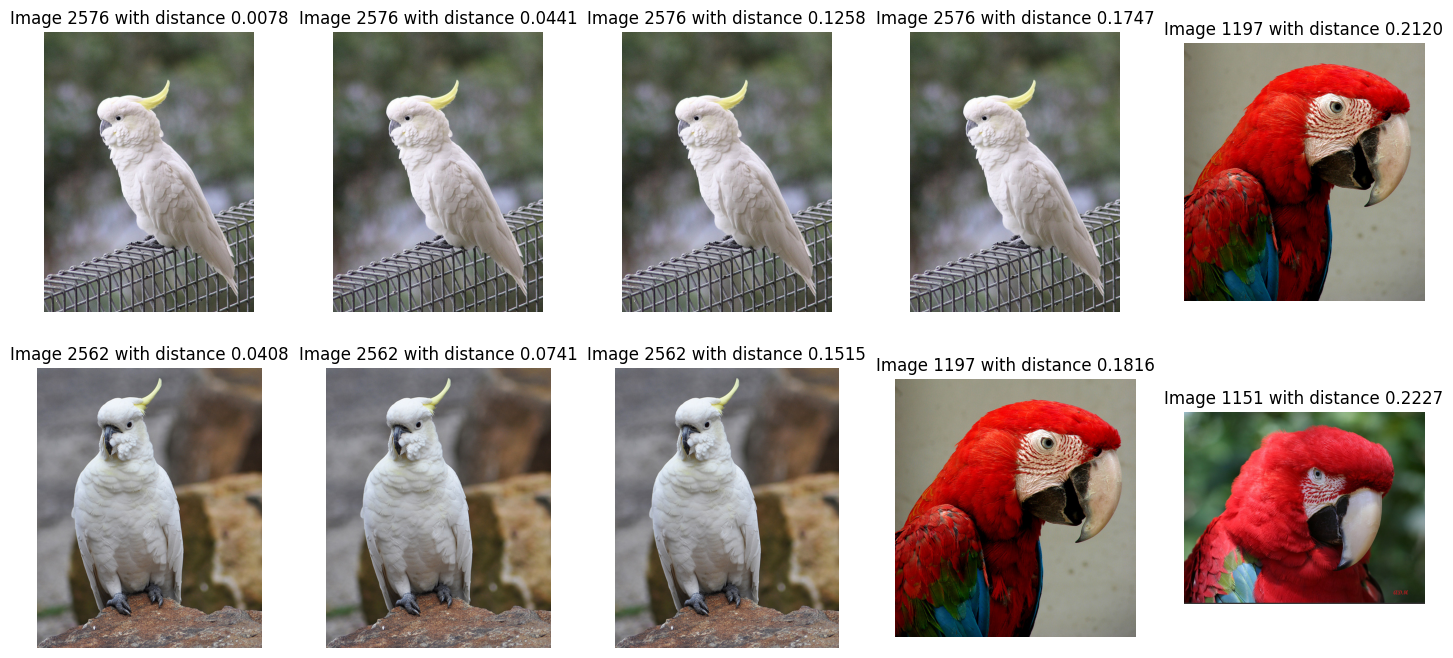

In [31]:
red_concept = concept_match_scores[vocab_names.index('red')].argmax()

fig, ax = plt.subplots(2, 5, figsize=(18, 8))
for i, value in enumerate([0, 10, 20, 25, 30]):
    with torch.no_grad():
        _, full_latents = sae_model.encode(clip_representations[img_index].reshape(1, -1))
        full_latents[:,red_concept] = value + mean_activations[red_concept]
        reconstructed = sae_model.model.decode(full_latents)
        post_reconstructed = sae_model.postprocess(reconstructed)
    
    distance, neighbours = clip_nn.kneighbors(post_reconstructed, 2, True)
    ax[0,i].imshow(Image.open(image_paths[neighbours[0,0]]).convert('RGB'))
    ax[0,i].axis('off')
    ax[0,i].set_title(f'Image {neighbours[0,0]} with distance {distance[0,0]:.4f}')
    ax[1,i].imshow(Image.open(image_paths[neighbours[0,1]]).convert('RGB'))
    ax[1,i].axis('off')
    ax[1,i].set_title(f'Image {neighbours[0,1]} with distance {distance[0,1]:.4f}')

As we increase the concept activation, the distance to the original image starts to get further away from our changed reference image. We see that by increasing the concept value to a very high value, we eventually start to get red birds as the most similar images, and even at 30, we get the red bird as the most similar.

Finally, to also touch on Section 5.3 from the paper, we will not train the classifier on the CelebA dataset but utilize CLIP's zero-shot classification capabilities. We'll also check how the probabilities change on our reference image `2576` as we increase the `red` concept activation. We will classify the image as `red bird` and `white bird` and see how the probabilities change as we increase the `red` concept activation.

As we increase the concept activation the distance to the original image is starting to further away from our changed reference image. We see by increasing the concept  with very high value eventually we start to get the red birds as the most similar images and even at concept value 30 we get the red bird as the most similar one.

Finally, to also touch the section 5.3 from the paper we will not train the classifier on CelebA dataset but utilize CLIP zero-shot classification capabilities and also check how the probabilities change on our reference image `2576` as we increase the `red` concept activation. We will classify the image as `red bird` or `white bird` and see how the probabilities change as we increase the `red` concept activation within the MSAE latents of the reference image `2576`.

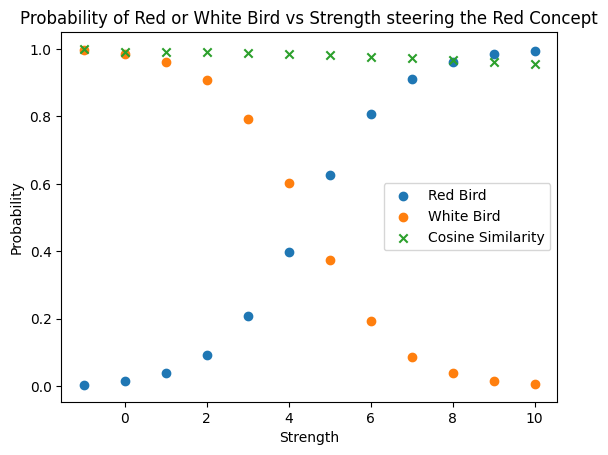

In [32]:
prob_red = []
prob_white = []
cos_sim = []
strengths = [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
red_concept = concept_match_scores[vocab_names.index('red')].argmax()

labels = clip.tokenize(["a photo of a red bird", "a photo of a white bird"])
with torch.no_grad():
    text_features = model.encode_text(labels)

text_features = text_features / text_features.norm(dim=1, keepdim=True)
text_features = model.logit_scale.exp() * text_features

image_features = clip_representations[img_index].reshape(1,-1)
image_features = image_features / image_features.norm(dim=1, keepdim=True)
probs = (image_features @ text_features.t()).softmax(dim=-1).detach().cpu().numpy()
prob_red.append(probs[0,0])
prob_white.append(probs[0,1])
cos_sim.append(torch.nn.functional.cosine_similarity(image_features, image_features).item())

for st in strengths[1:]:
    with torch.no_grad():
        _, full_latents = sae_model.encode(clip_representations[img_index].reshape(1, -1))
        full_latents[:,red_concept] = st + mean_activations[red_concept]
        reconstructed = sae_model.model.decode(full_latents)
        post_reconstructed = sae_model.postprocess(reconstructed)

    post_reconstructed = post_reconstructed / post_reconstructed.norm(dim=1, keepdim=True)
    probs = (post_reconstructed @ text_features.t()).softmax(dim=-1).detach().cpu().numpy()
    prob_red.append(probs[0,0])
    prob_white.append(probs[0,1])
    cos_sim.append(torch.nn.functional.cosine_similarity(post_reconstructed, image_features).item())

plt.scatter(strengths, prob_red, label='Red Bird')
plt.scatter(strengths, prob_white, label='White Bird')
plt.scatter(strengths, cos_sim, label='Cosine Similarity', marker='x')
plt.title('Probability of Red or White Bird vs Strength steering the Red Concept')
plt.xlabel('Strength')
plt.ylabel('Probability')
plt.legend()
plt.show()
